In [9]:
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt

from glob import glob
from pathlib import Path
import torch

In [10]:
def load_mask():
    print('loading mask...')
    rle_masks = pd.read_csv('../input/model_50A_slim_ensemble.csv')
    rle_masks = rle_masks[rle_masks['rle_mask'].isnull() == False]
    rle_masks.index = rle_masks['id']
    del rle_masks['id']
    rle_masks = rle_masks.to_dict('index')
    return rle_masks

In [11]:
rle_masks = load_mask()

loading mask...


In [16]:
rle_masks['0037e7d3']

{'rle_mask': '3731 6 3923 7 4114 10 4306 11 4498 11 4690 12 4882 12 5075 12 5266 13 5457 14 5649 15 5842 14 6034 15 6227 15 6419 15 6611 16 6803 16 6995 16 7187 16 7379 16 7572 16 7764 16 7956 17 8148 17 8340 17 8531 18 8723 18 8915 19 9107 19 9298 20 9490 20 9682 20 9874 20 10066 21 10258 21 10449 22 10641 22 10833 23 11026 22 11217 23 11409 23 11600 24 11792 25 11984 25 12176 25 12368 25 12560 25 12752 26 12944 26 13136 26 13328 26 13520 26 13712 27 13904 27 14096 27 14288 27 14480 28 14672 28 14864 28 15056 29 15248 29 15440 29 15632 29 15824 29 16016 30 16208 30 16400 30 16592 30 16785 29 16977 30 17169 30 17361 30 17553 31 17745 31 17937 31 18129 32 18322 31 18514 31 18706 31 18898 32 19090 32 19282 32 19474 33 19666 33 19858 33 20051 33 20243 33 20436 32 20628 32 20820 33 21011 34 21203 34 21395 35 21587 35 21779 35 21971 36 22163 36 22356 35 22548 36 22740 36 22932 36 23124 37 23317 36 23509 36 23701 36 23893 37 24085 37 24277 37 24469 37 24662 37 24854 37 25046 37 25238 38 2543

In [18]:
def do_length_decode(rle, H=192, W=384, fill_value=255):
    mask = np.zeros((H,W), np.uint8)
    if type(rle).__name__ == 'float': return mask
    mask = mask.reshape(-1)
    rle = np.array([int(s) for s in rle.split(' ')]).reshape(-1, 2)
    for r in rle:
        start = r[0]-1
        end = start + r[1]
        mask[start : end] = fill_value
    mask = mask.reshape(W, H).T   # H, W need to swap as transposing.
    return mask

In [19]:
name = '0037e7d3'
mask = do_length_decode(rle_masks[name.split('.')[0]]['rle_mask'])

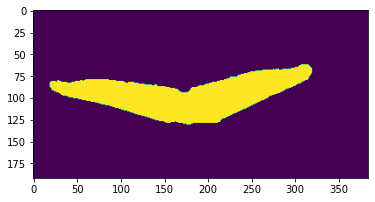

In [20]:
plt.imshow(mask)
plt.show()

In [21]:
mask.shape

(192, 384)

(700, 1050, 3)

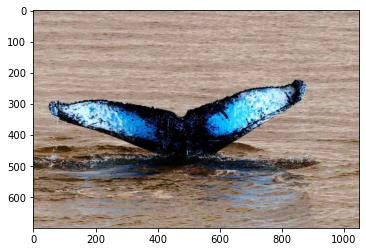

In [22]:
image = cv2.imread(f'../input/train/{name}.jpg') 
plt.imshow(image);image.shape

In [23]:
mask = cv2.resize(mask, image.shape[:2][::-1])

In [24]:
mask.shape

(700, 1050)

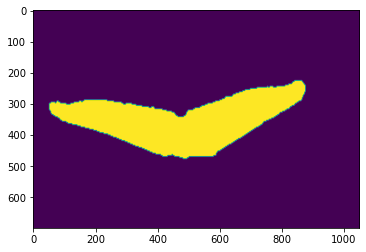

In [25]:
plt.imshow(mask)
plt.show()

In [28]:
def load_bbox():
    # Image,x0,y0,x1,y1
    print('loading bbox...')
    bbox = pd.read_csv('../input/bboxs.csv')
    Images = bbox['Image'].tolist()
    x0s = bbox['x0'].tolist()
    y0s = bbox['y0'].tolist()
    x1s = bbox['x1'].tolist()
    y1s = bbox['y1'].tolist()
    bbox_dict = {}
    for Image,x0,y0,x1,y1 in zip(Images,x0s,y0s,x1s,y1s):
        bbox_dict[Image] = [x0, y0, x1, y1]
    return bbox_dict

In [29]:
bbox_dict = load_bbox()

loading bbox...


In [30]:
x0, y0, x1, y1 = bbox_dict[f'{name}.jpg']

In [31]:
image = image[int(y0):int(y1), int(x0):int(x1)]

In [32]:
mask = mask[int(y0):int(y1), int(x0):int(x1)]

(255, 825, 3)

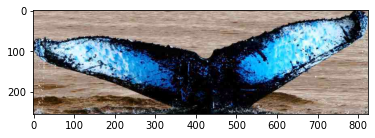

In [33]:
plt.imshow(image); image.shape

(255, 825)

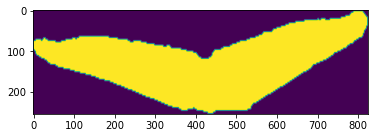

In [34]:
plt.imshow(mask); mask.shape

In [35]:
def transform_valid(image, mask):
    print ('transform_valid', image.shape, mask.shape)

    images = []
    # ipdb.set_trace()
    image = cv2.resize(image, (512, 256))
    mask = cv2.resize(mask, (512, 256))
    mask = mask[:, :, None]
    image = np.concatenate([image, mask], 2)
    raw_image = image.copy()

    image = np.transpose(raw_image, (2, 0, 1))
    image = image.copy().astype(np.float)
    image = torch.from_numpy(image).div(255).float()
    images.append(image)

    image = np.fliplr(raw_image)
    image = np.transpose(image, (2, 0, 1))
    image = image.copy().astype(np.float)
    image = torch.from_numpy(image).div(255).float()
    images.append(image)
    return images

In [36]:
img1, img2 = transform_valid(image, mask)

transform_valid (255, 825, 3) (255, 825)


In [37]:
img1.shape

torch.Size([4, 256, 512])

In [38]:
img2.shape

torch.Size([4, 256, 512])

In [39]:
img1

tensor([[[0.7647, 0.7529, 0.7451,  ..., 0.6745, 0.6510, 0.6471],
         [0.8000, 0.8078, 0.8118,  ..., 0.7098, 0.7216, 0.7137],
         [0.7725, 0.7922, 0.8039,  ..., 0.6667, 0.6902, 0.6902],
         ...,
         [0.6510, 0.6588, 0.6902,  ..., 0.5490, 0.5294, 0.5451],
         [0.6902, 0.6196, 0.5098,  ..., 0.6235, 0.6000, 0.4902],
         [0.4941, 0.5294, 0.4157,  ..., 0.5569, 0.5686, 0.4275]],

        [[0.6784, 0.6667, 0.6588,  ..., 0.5647, 0.5451, 0.5490],
         [0.7137, 0.7216, 0.7255,  ..., 0.5961, 0.6157, 0.6196],
         [0.6863, 0.7059, 0.7137,  ..., 0.5569, 0.5922, 0.5961],
         ...,
         [0.5922, 0.6118, 0.6549,  ..., 0.5255, 0.5059, 0.5216],
         [0.6392, 0.5725, 0.4745,  ..., 0.6000, 0.5765, 0.4667],
         [0.4392, 0.4941, 0.3882,  ..., 0.5333, 0.5451, 0.4039]],

        [[0.6314, 0.6196, 0.6118,  ..., 0.5255, 0.5059, 0.5020],
         [0.6667, 0.6745, 0.6784,  ..., 0.5686, 0.5765, 0.5725],
         [0.6392, 0.6588, 0.6667,  ..., 0.5294, 0.5529, 0.